In [31]:
# Source: https://github.com/alan-turing-institute/sktime/blob/main/examples/01_forecasting.ipynb
# Source: https://www.kaggle.com/nageshsingh/stock-market-forecasting-arima
# Source: https://www.kaggle.com/mtszkw/xgboost-for-stock-trend-prices-prediction

from warnings import simplefilter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mplfinance as fplt

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from sklearn.model_selection import TimeSeriesSplit

from pylab import rcParams
rcParams['figure.figsize'] = 10,6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL

import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [32]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [33]:
py.offline.init_notebook_mode()

# Analyzing Apple Stock

1. Load Apple Stock data and drop unneeded columns -> We will focus on the closing price as the label to predict
2. Visualize the closing price of the stock over the entire data set.
3. Ensure there are no missing values in the series. If so, fill them appropriately.
3. Is the stock stationary?
    * To do this, we can do a Augment Dickey -Fuller Test that determines if there is a unit root in the series
    To read more: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
4. Separate out seasonality and trend to observe changes in stock price

# Features

We will engineer our own features based on the available data. We will use a variety of features however most will be
based around well known technical indicators such as moving average, exponential moving averages, momentum, Bollinger
Bands, Price volume Trend etc. For a more exhaustive list, please view the report at TODO

### ADF (Augmented Dickey-Fuller) Test

This will help us determine if there is a unit root in our time series (indicating stationary vs non-stationary)

Stationary Time Series: A time series whose properties do not depend on the time at which the series is observed. I.e
time series with trends or seasonality are not stationary. This is relevant as this will dictate how we select features
or engineer them as well as inform our algorithms.

In order to effectively predict a time series, we must make it stationary by removing trend and seasonality from it.
A stationary series will be roughly horizontal over the long term. Our goal is to use machine learning to predict this.

Null Hypothesis: The series has a unit root.
Alternative Hypothesis: The series has no unit root.

If null hypothesis is not rejected, we can that the series is non-stationary.

## Feature Engineering

We will create several engineered features which will be used for our prediction:

1. Exponential moving average (9, 5 and 35 days)
2. Standard moving average (5, 10, 15, 30 days)
3. RSI - Relative strength index
4. MACD - Momentum indicator

In [34]:
def preprocess_data(df_stock, date_range=('2005-01-01', '2021-01-01')):
    # sets the dataframe so it is indexed by date instead of integers
    df_stock.index = pd.to_datetime(df_stock.index)
    
    # Drop unneeded column
    df_stock.drop(columns='OpenInt', inplace=True)
    
    # Check if we have any missing values
    print(f'Number of Missing Values: {df_stock.isnull().sum()}')
    
    # Set up our date range for the data. By default, it starts at 2007 and ends at 01 Jan 2021
    df_stock = df_stock.loc[date_range[0]:date_range[1]]
    
    # Rearrange the columns for easier manipulation later:
    df_stock = df_stock[['Close', 'Open', 'High', 'Low', 'Volume']]
    
    return df_stock
    
# Relative Strength Index: Momentum indicator that measures the magnitude of the prices changes to see if a share is
# overbought or sold. Values lie between 0 and 100. If a value is above 70 indicates overbought or overvalued while
# below 30 indicates oversold or undervalued.

# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
def calculate_rsi(df, period=14):
    delta = df['Close'].diff()

    dUp = delta.copy()
    dDown = delta.copy()

    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    rollUP = dUp.rolling(period).mean()
    rollDOWN = dDown.abs().rolling(period).mean()

    rs = rollUP/rollDOWN

    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

def create_indicators(df, dropnan = True):
    # Create a copy of the dataset to not touch the original 
    df_stock = df.copy()
    
    # Moving averages:
    # Exponential moving average with a different spans 
    # Additional info: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
    df_stock['EMA_5'] = df_stock['Close'].ewm(span=5, min_periods=5).mean()
    df_stock['EMA_9'] = df_stock['Close'].ewm(span=9, min_periods=9).mean()
    df_stock['EMA_35'] = df_stock['Close'].ewm(span=35, min_periods=35).mean()


    # These are standard moving averages. They do not take into account any history of the closing price beyond what is
    # explicitly within the window specified within the rolling() function.
    df_stock['SMA_5'] = df_stock['Close'].rolling(5).mean()
    df_stock['SMA_10'] = df_stock['Close'].rolling(10).mean()
    df_stock['SMA_15'] = df_stock['Close'].rolling(15).mean()
    df_stock['SMA_30'] = df_stock['Close'].rolling(30).mean()
    
    df_stock['RSI'] = calculate_rsi(df_stock)
    
    EMA_12 = df_stock['Close'].ewm(span=12).mean()
    EMA_26 = df_stock['Close'].ewm(span=26).mean()

    df_stock['MACD'] = EMA_26 - EMA_12
    df_stock['MACD_Signal'] = df_stock['MACD'].ewm(span=9, min_periods=9).mean()
    
    # remove NA rows:
    if dropnan:
        df_stock.dropna(inplace=True)

    return df_stock

def reshape_timeseries(df, time_steps_in, time_steps_out, dropnan=True):
    # Create a copy to not change the original dataframe accidentally 
    df_stock = df.copy()
    
    # Our objective is reshape our data set so it is suitable for our lstm
    # LSTMS expect the input data to be in this shape [samples, timesteps, features]
    # so 3d data with the one axis being number of steps in time we are looking back to make
    # a forecast
    
    # time_steps_in: number of time steps in the past to look
    # time_steps_out: number of time steps ahead to predict
    
    # we assume that the date column has been removed or added as the indexer
    variable_count = df_stock.shape[1]
    
    columns_current = list(df_stock.columns)
    cols = list()
    names = list()
    
    # here we add past observations as new columns! this will be used as input
    for i in range(time_steps_in, 0, -1): # go in reverse-> counting down
        cols.append(df_stock.shift(i))
        names += [f'{col_name}(t-{i})' for col_name in columns_current]
   
    # here we move t+1 -> ie future observations -> These will be used as output. 
    for i in range(0, time_steps_out):
        cols.append(df_stock.shift(-i))
        if i == 0:
            names += [f'{col_name}(t)' for col_name in columns_current]
        else:
            names += [f'{col_name}(t+{i})' for col_name in columns_current]
            
    aggregated_df = pd.concat(cols, axis=1)
    aggregated_df.columns = names
    
    if dropnan:
        aggregated_df.dropna(inplace=True)
        
    return aggregated_df
    

In [35]:
# LOAD DATA SET

STOCK_NAME = 'AAPL'

df_stock = pd.read_csv(f'data_files/Stocks/{STOCK_NAME.lower()}.us.txt', index_col=0)

# Preprocess our data set for some initial cleaning. 
df_stock = preprocess_data(df_stock)

# Add indicators to our data:
df_stock_w_indicators = create_indicators(df_stock, dropnan=True)

Number of Missing Values: Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [36]:
# Visualize original Dataframe
df_stock.head()

Close    Open    High     Low     Volume
Date                                                 
2005-01-03  4.0519  4.1529  4.1685  4.0083  193279926
2005-01-04  4.0940  4.0825  4.1915  4.0314  306165093
2005-01-05  4.1300  4.0940  4.1775  4.0940  189804833
2005-01-06  4.1324  4.1491  4.1556  4.0545  196766476
2005-01-07  4.4336  4.1646  4.4578  4.1469  623374174

In [37]:
# Visualize preprocessed Dataframe
df_stock_w_indicators

Close      Open      High       Low     Volume       EMA_5  \
Date                                                                        
2005-02-22    5.4619    5.5348    5.6540    5.4619  340038882    5.516710   
2005-02-23    5.6499    5.5540    5.6643    5.4772  375007448    5.561107   
2005-02-24    5.6951    5.6499    5.7192    5.6183  425376517    5.605771   
2005-02-25    5.6975    5.7411    5.7564    5.6461  255345043    5.636348   
2005-02-28    5.7449    5.7192    5.7807    5.6295  182064525    5.672532   
...              ...       ...       ...       ...        ...         ...   
2017-11-06  173.6300  171.7500  174.3600  171.1000   34901241  169.605323   
2017-11-07  174.1800  173.2900  174.5100  173.2900   24424877  171.130215   
2017-11-08  175.6100  174.0300  175.6100  173.7100   24451166  172.623477   
2017-11-09  175.2500  174.4800  175.4600  172.5200   29533086  173.498984   
2017-11-10  174.6700  175.1100  175.3800  174.2700   25130494  173.889323   

                 EMA_9      EMA_35      SMA_5     SMA_10      SMA_15  \
Date                                                                   
2005-02-22    5.430032    5.051878    5.61500    5.39320    5.272067   
2005-02-23    5.474020    5.089967    5.61288    5.44016    5.317713   
2005-02-24    5.518247    5.128198    5.59780    5.50548    5.357520   
2005-02-25    5.554105    5.163894    5.61270    5.57349    5.405160   
2005-02-28    5.592271    5.200064    5.64986    5.62804    5.451587   
...                ...         ...        ...        ...         ...   
2017-11-06  166.708798  160.168354  169.54800  164.55700  162.092000   
2017-11-07  168.203038  160.946779  170.69800  166.32100  163.044000   
2017-11-08  169.684431  161.761402  172.56200  168.29700  164.138667   
2017-11-09  170.797544  162.510769  174.11000  170.13700  165.460667   
2017-11-10  171.572036  163.186282  174.66800  171.35700  166.726000   

                SMA_30        RSI      MACD  MACD_Signal  
Date                                                      
2005-02-22    4.896380  64.872148 -0.229852    -0.200185  
2005-02-23    4.937520  65.996174 -0.233619    -0.206874  
2005-02-24    4.989563  71.514016 -0.237293    -0.212959  
2005-02-25    5.039763  70.383166 -0.237621    -0.217893  
2005-02-28    5.082287  71.135598 -0.238758    -0.222066  
...                ...        ...       ...          ...  
2017-11-06  158.380667  74.079270 -3.806569    -2.161603  
2017-11-07  159.100333  76.437390 -4.245416    -2.578366  
2017-11-08  159.831333  88.811995 -4.654936    -2.993680  
2017-11-09  160.582000  87.471264 -4.894020    -3.373748  
2017-11-10  161.285333  85.827068 -4.979296    -3.694857  

[3205 rows x 15 columns]

In [38]:
# Show basic information about the stock:
df_stock_last_month = df_stock.loc['2016-11-01':'2016-12-31']
candlestick = go.Candlestick(
    x=df_stock_last_month.index,
    open=df_stock_last_month['Open'],
    close=df_stock_last_month['Close'],
    high=df_stock_last_month['High'],
    low=df_stock_last_month['Low']
)

fig = go.Figure(data=[candlestick])

fig.update_layout(
    title=f'Candlesticks Chart for {STOCK_NAME} Stock Between {min(df_stock_last_month.index).strftime("%b-%d-%Y")} and {max(df_stock_last_month.index).strftime("%b-%d-%Y")}',
    yaxis_title='Stock Price ($)',
    height = 500,
    width = 800,
)
fig.show()
fig.write_image('candles-201.png')

In [39]:

fig = make_subplots(rows=2, cols=1, subplot_titles = ('Closing Price and Moving Averages', 'Momentum Indicators (MACD & Signal)'))


fig.add_trace(go.Scatter(x=df_stock_last_month.index, y=df_visualize.EMA_9, name='EMA_9'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_stock_last_month.index, y=df_visualize.SMA_10, name='SMA_10'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_stock_last_month.index, y=df_visualize.SMA_30, name='SMA_30'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_stock_last_month.index, y=df_visualize.Close, name='Close'),  row=1, col=1)
fig.add_trace(go.Candlestick(
    x=df_stock_last_month.index,
    open=df_visualize['Open'],
    close=df_visualize['Close'],
    high=df_visualize['High'],
    low=df_visualize['Low'],
    name='Candles'
))

fig.add_trace(go.Scatter(x=df_visualize.index, y=df_visualize['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_visualize.index, y=df_visualize['MACD_Signal'], name='Signal line'), row=2, col=1)

fig.update_layout(
    title = 'Visual Analysis of Stock Prices', 
    height = 850,
    width = 1200,
    xaxis_rangeslider_visible=False
    
)

fig.update_yaxes(title='USD')
fig.write_image('indicators_with_candles.png')
fig.show()

In [40]:
df_stock_w_indicators

Close      Open      High       Low     Volume       EMA_5  \
Date                                                                        
2005-02-22    5.4619    5.5348    5.6540    5.4619  340038882    5.516710   
2005-02-23    5.6499    5.5540    5.6643    5.4772  375007448    5.561107   
2005-02-24    5.6951    5.6499    5.7192    5.6183  425376517    5.605771   
2005-02-25    5.6975    5.7411    5.7564    5.6461  255345043    5.636348   
2005-02-28    5.7449    5.7192    5.7807    5.6295  182064525    5.672532   
...              ...       ...       ...       ...        ...         ...   
2017-11-06  173.6300  171.7500  174.3600  171.1000   34901241  169.605323   
2017-11-07  174.1800  173.2900  174.5100  173.2900   24424877  171.130215   
2017-11-08  175.6100  174.0300  175.6100  173.7100   24451166  172.623477   
2017-11-09  175.2500  174.4800  175.4600  172.5200   29533086  173.498984   
2017-11-10  174.6700  175.1100  175.3800  174.2700   25130494  173.889323   

                 EMA_9      EMA_35      SMA_5     SMA_10      SMA_15  \
Date                                                                   
2005-02-22    5.430032    5.051878    5.61500    5.39320    5.272067   
2005-02-23    5.474020    5.089967    5.61288    5.44016    5.317713   
2005-02-24    5.518247    5.128198    5.59780    5.50548    5.357520   
2005-02-25    5.554105    5.163894    5.61270    5.57349    5.405160   
2005-02-28    5.592271    5.200064    5.64986    5.62804    5.451587   
...                ...         ...        ...        ...         ...   
2017-11-06  166.708798  160.168354  169.54800  164.55700  162.092000   
2017-11-07  168.203038  160.946779  170.69800  166.32100  163.044000   
2017-11-08  169.684431  161.761402  172.56200  168.29700  164.138667   
2017-11-09  170.797544  162.510769  174.11000  170.13700  165.460667   
2017-11-10  171.572036  163.186282  174.66800  171.35700  166.726000   

                SMA_30        RSI      MACD  MACD_Signal  
Date                                                      
2005-02-22    4.896380  64.872148 -0.229852    -0.200185  
2005-02-23    4.937520  65.996174 -0.233619    -0.206874  
2005-02-24    4.989563  71.514016 -0.237293    -0.212959  
2005-02-25    5.039763  70.383166 -0.237621    -0.217893  
2005-02-28    5.082287  71.135598 -0.238758    -0.222066  
...                ...        ...       ...          ...  
2017-11-06  158.380667  74.079270 -3.806569    -2.161603  
2017-11-07  159.100333  76.437390 -4.245416    -2.578366  
2017-11-08  159.831333  88.811995 -4.654936    -2.993680  
2017-11-09  160.582000  87.471264 -4.894020    -3.373748  
2017-11-10  161.285333  85.827068 -4.979296    -3.694857  

[3205 rows x 15 columns]

## Prep our date for non-LSTM ML:

1. Add a new column which shifts the closing price by -1 -> one day ahead. This is what we will try to predict. 
2. Use ML algorithms and compare their performance to see which one does well. 

In [41]:
# Split up our data set in training, validation and test:
# Simple Splitting

# Add normal int indices:
df_stock_w_indicators = df_stock_w_indicators.reset_index()

df_stock_w_indicators['Close_Tomorrow'] = df_stock_w_indicators['Close'].shift(-1)
df_stock_w_indicators.dropna(inplace=True)

TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2
TRAIN_SIZE = 0.8

# Sizes were chosen as our data set is not very large. 

test_split_idx = int(len(df_stock_w_indicators) * (1-TEST_SIZE))
valid_split_idx = int(len(df_stock_w_indicators) * (1-VALIDATION_SIZE-TEST_SIZE))

train_df = df_stock_w_indicators.iloc[:valid_split_idx, :]
validation_df = df_stock_w_indicators.iloc[valid_split_idx:test_split_idx, :]
test_df = df_stock_w_indicators.iloc[test_split_idx:, :]

assert(len(df_stock_w_indicators) == len(train_df) + len(validation_df) + len(test_df))

X_train, y_train = train_df.iloc[:, 1:-1].values, train_df.iloc[:, -1].values
X_validation, y_validation = validation_df.iloc[:, 1:-1].values, validation_df.iloc[:, -1].values
X_test, y_test = test_df.iloc[:, 1:-1].values, test_df.iloc[:, -1].values




In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=validation_df.Date, y=validation_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))

fig.update_layout(
    title = 'Splitting Data for Training, Validation and Testing (0.6, 0.2, 0.2)',
    height = 500,
    width = 800,
)
fig.show()
fig.write_image('data_split.png')

## Now we have our date ready to be used with some of sklearn's regressors.

Lets test with several regressors
1. Random Forest Regressor
2. KNeighbours Regressor
3. Support Vector Machine Regressor (RBF)
4. Histogram-based Gradient Boosting Regression Tree

In [44]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [45]:
# Initializing Models:

rfr = RandomForestRegressor(n_jobs = 4, criterion='mse', )
knr = KNeighborsRegressor(n_jobs=4)
hgbr = HistGradientBoostingRegressor(loss='least_squares', max_iter=100)

predictions = dict()

In [46]:
# Support Vector Regressor with RBF Kernel:
# We must scale data before using an SVR so we create a pipeline:

svr_pipe = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', gamma='auto', tol=1e-3, max_iter=-1),
)

In [47]:
# Train Our Regressors:
svr_pipe.fit(X_train, y_train)
rfr.fit(X_train, y_train)
knr.fit(X_train, y_train)
hgbr.fit(X_train, y_train)

HistGradientBoostingRegressor()

In [70]:
# Predict Training Data with Our Regressors
predictions['SVR'] = svr_pipe.predict(X_train)
predictions['RFR'] = rfr.predict(X_train)
predictions['KNR'] = knr.predict(X_train)
predictions['HGBR'] = hgbr.predict(X_train)

# Plot predicted vs real data:
fig = go.Figure()
fig.add_trace(go.Scattergl(x=train_df['Date'], y=y_train, name='Training Data'))

for key, val in predictions.items():
    fig.add_trace(go.Scattergl(x=train_df['Date'], y=val, name=key))
    
fig.update_layout(
    title='Predictions with Simple Regressors on our Training Data',
    height = 500,
    width = 800,
)

fig.show()

In [71]:
# Predict Validation Data with Our Regressors
predictions['SVR'] = svr_pipe.predict(X_validation)
predictions['RFR'] = rfr.predict(X_validation)
predictions['KNR'] = knr.predict(X_validation)
predictions['HGBR'] = hgbr.predict(X_validation)

# Plot predicted vs real data:
fig = go.Figure()
fig.add_trace(go.Scattergl(x=validation_df['Date'], y=y_validation, name='Validation Data'))

for key, val in predictions.items():
    fig.add_trace(go.Scattergl(x=validation_df['Date'], y=val, name=key))
    
fig.update_layout(
    title='Predictions with Simple Regressors on our Validation Data',
    height = 500,
    width = 800,
)

fig.show()

## Preliminary Conclusions

* We can see right away that our some algorithms are better suited to this data than others (i.e KNeihgbours is not suitable for this kind of task)
* We can also see that with our validation data, we are able to follow the trend right until June 2014 with most of our regressors.

This bring us to our next idea, a de-trender! A detrender utilizes linear regression to remove the underlying year over year trend so that our base ml model is only modelling the underlying pattern within our output data. 

1. Find the underlying trend in our data via linear regression
2. Remove the underlying trend so only residuals are left.
3. Use the residuals as training labels. 
4. Predict and re-trend to get real value of stock. 

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# We call the Statsmodels.tsa.STL class -> Seasonal Trend Decomposition using LOESS
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html

train_df_stl = train_df.set_index('Date')

result_stl = STL(train_df_stl['Close_Tomorrow'], period=365).fit()

# The result_stl stores several important things. We are primarily interested in the resid -> residuals and trend! 
# We are going to use the trend data to create a linear regression algorithm which will then be used in a pipeline
# Our x here will be the index of our data. For prediction, we must use the appropriate int index which will be based on the date we want to predict for. 
# Our starting date is 2007-02-22 -> comes from train_df
linear_trend_model = LinearRegression()
x_array_len = np.arange(0, len(train_df_stl), 1).reshape(-1, 1)

linear_trend_model.fit(x_array_len, result_stl.trend)
trend_linear = linear_trend_model.predict(x_array_len)

# We will also try polynomial regression to see if it shows a bette fit on the overall trend!
poly_trend_model = make_pipeline(
    PolynomialFeatures(4),
    LinearRegression()
)

poly_trend_model.fit(x_array_len, result_stl.trend)
trend_poly = poly_trend_model.predict(x_array_len)


fig = go.Figure()

fig.add_trace(go.Scattergl(x=train_df_stl.index, y=train_df_stl['Close_Tomorrow'].values, name= 'Real Training Data'))
fig.add_trace(go.Scattergl(x=result_stl.resid.index, y=result_stl.resid.values, name='Detrended Training Data'))
fig.add_trace(go.Scattergl(x=result_stl.resid.index, y=trend_linear, name='Linear Trend'))
fig.add_trace(go.Scattergl(x=result_stl.resid.index, y=trend_poly, name='Polynomial Trend'))
fig.update_layout(
    title='Detrending Our Output Variable (Closing Price +1)'
)
fig.show()

# Conclusions about Trend

We can see that there is an underlying overall trend in our data which can be extracted from the day to day changes as a linear trend. It can also be extracted via polynomial regression. This will depend on the stock in question and its past performance. In this case, we opt for the polynomial trend. 

In [64]:
# Detrend our y -> 
train_df_stl = train_df.set_index('Date')
result_stl = STL(train_df_stl['Close_Tomorrow'], period=365).fit()

# Learn a linear and polynomial model for our trend:

# These idx will be needed to calculate our 
idx_train = np.arange(0, len(y_train), 1).reshape(-1, 1)
idx_validation = np.arange(max(idx_train), max(idx_train) + len(y_validation), 1).reshape(-1,1)
idx_test = np.arange(max(idx_validation), max(idx_validation) + len(y_test), 1).reshape(-1,1)

linear_trend_model = LinearRegression()
linear_trend_model.fit(idx_train, result_stl.trend)


# We will also try polynomial regression to see if it shows a bette fit on the overall trend!
poly_trend_model = make_pipeline(
    PolynomialFeatures(4),
    LinearRegression()
)

poly_trend_model.fit(idx_train, result_stl.trend)

# Use detreneded y to train our regressors
y_train_detrended = result_stl.resid.values

# Train Our Regressors (no k-neighbours):
svr_pipe.fit(X_train, y_train_detrended)
rfr.fit(X_train, y_train_detrended)
hgbr.fit(X_train, y_train_detrended)

# predict values for training data with regressors:
predictions_train = dict()
predictions_train['SVR'] = svr_pipe.predict(X_train)
predictions_train['RFR'] = rfr.predict(X_train)
predictions_train['HGBR'] = hgbr.predict(X_train)


# Predict Validation Data with Our Regressors
predictions_validation = dict()
predictions_validation['SVR'] = svr_pipe.predict(X_validation)
predictions_validation['RFR'] = rfr.predict(X_validation)
predictions_validation['HGBR'] = hgbr.predict(X_validation)


# Retrend the predictions with just linear regression
trend_train = linear_trend_model.predict(idx_train)
trend_validate = linear_trend_model.predict(idx_validation)
trend_test = linear_trend_model.predict(idx_test)

for key, val in predictions_train.items():
    predictions_train[key] = val + trend_train
for key, val in predictions_validation.items():
    predictions_validation[key] = val + trend_validate




In [72]:
# Plot predictions against real data and and calculate error
# Plot predicted vs real data:

fig = go.Figure()
fig.add_trace(go.Scattergl(x=train_df['Date'], y=y_train, name='Training Data'))

for key, val in predictions_train.items():
    fig.add_trace(go.Scattergl(x=train_df['Date'], y=val, name=key))
    
fig.update_layout(
    title='Predictions with Detrending and Retrending with Linear Regression (Training Data)',
    height = 500,
    width = 800,
)

fig.show()

In [74]:
# Plot predictions against real data and and calculate error
# Plot predicted vs real data:
fig = go.Figure()
fig.add_trace(go.Scattergl(x=validation_df['Date'], y=y_validation, name='Validation Data'))

for key, val in predictions_validation.items():
    fig.add_trace(go.Scattergl(x=validation_df['Date'], y=val, name=key))
    
fig.update_layout(
    title='Predictions with Detrending and Retrending with Linear Regression (Validation Data)',
    height = 500,
    width = 800,
)

fig.show()

In [75]:
# Lets try with polynomial regression detrending 

# predict values for training data with regressors:
predictions_train = dict()
predictions_train['SVR'] = svr_pipe.predict(X_train)
predictions_train['RFR'] = rfr.predict(X_train)
predictions_train['HGBR'] = hgbr.predict(X_train)


# Predict Validation Data with Our Regressors
predictions_validation = dict()
predictions_validation['SVR'] = svr_pipe.predict(X_validation)
predictions_validation['RFR'] = rfr.predict(X_validation)
predictions_validation['HGBR'] = hgbr.predict(X_validation)


# Retrend the predictions with just linear regression
trend_train = poly_trend_model.predict(idx_train)
trend_validate = poly_trend_model.predict(idx_validation)
trend_test = poly_trend_model.predict(idx_test)

for key, val in predictions_train.items():
    predictions_train[key] = val + trend_train
for key, val in predictions_validation.items():
    predictions_validation[key] = val + trend_validate

In [76]:
# Plot predictions against real data and and calculate error
# Plot predicted vs real data:

fig = go.Figure()
fig.add_trace(go.Scattergl(x=train_df['Date'], y=y_train, name='Training Data'))

for key, val in predictions_train.items():
    fig.add_trace(go.Scattergl(x=train_df['Date'], y=val, name=key))
    
fig.update_layout(
    title='Predictions with Detrending and Retrending with Linear Regression (Training Data)',
    height = 500,
    width = 800,
)

fig.show()

In [77]:
# Plot predictions against real data and and calculate error
# Plot predicted vs real data:
fig = go.Figure()
fig.add_trace(go.Scattergl(x=validation_df['Date'], y=y_validation, name='Validation Data'))

for key, val in predictions_validation.items():
    fig.add_trace(go.Scattergl(x=validation_df['Date'], y=val, name=key))
    
fig.update_layout(
    title='Predictions with Detrending and Retrending with Linear Regression (Validation Data)',
    height = 500,
    width = 800,
)

fig.show()

## Detrend? Did it work?

Our results indicate that trending and detrending may not be a great solution for combining with regressors as our regressor completely miss the mark when we try to retrend our data. 
This might be remedied by a more complex trend equation that takes into account other factors like seasonality. Given the amount of time available, we couldn't explore this option further. 

# LSTM Implementation

1. Transform our data for an LSTM format (it must have the shape: [samples, timesteps, features]) 
2. Tune LSTM parameters using validation set
3. Train LSTM for multiple horizons: 1 day, 3 days, 5 days
4. Test LSTM performance via test set

In [38]:
# We have 2700 instances of our data -> 20% Test, 20% Validation and 60% Training set (540, 540, 1620)

X_train, y_train = X.iloc[:1620, :].values, y.iloc[:1620, :].values
X_validation, y_validation = X.iloc[1620:2160, :].values, y.iloc[1620:2160, :].values
X_test, y_test = X.iloc[2160:, :].values, y.iloc[2160:, :].values
dates_test = df_stock['Date'][2160:]

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler_x.fit_transform(X_train)
X_validation_scaled = scaler_x.transform(X_validation)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_validation_scaled = scaler_y.transform(y_validation)
y_test_scaled = scaler_y.transform(y_test)


In [22]:
# Reshape our data:

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_validation_scaled = X_validation_scaled.reshape((X_validation_scaled.shape[0], 1, X_validation_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f'Train X Shape: {X_train_scaled.shape}\nValidation X Shape: {X_validation_scaled.shape}\nTest X Shape: {X_test_scaled.shape}')

Train X Shape: (1620, 1, 12)
Validation X Shape: (540, 1, 12)
Test X Shape: (540, 1, 12)


In [23]:
# Define our model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Train our network:
history = model.fit(X_train_scaled, y_train_scaled,
                   epochs=20,
                   batch_size=72,
                   validation_data=(X_validation_scaled, y_validation_scaled),
                   shuffle=False)

Epoch 1/20
23/23 - 4s - loss: 0.2193 - val_loss: 0.5795
Epoch 2/20
23/23 - 0s - loss: 0.1098 - val_loss: 0.1901
Epoch 3/20
23/23 - 0s - loss: 0.0977 - val_loss: 0.0762
Epoch 4/20
23/23 - 0s - loss: 0.0452 - val_loss: 0.0459
Epoch 5/20
23/23 - 0s - loss: 0.0231 - val_loss: 0.0254
Epoch 6/20
23/23 - 0s - loss: 0.0181 - val_loss: 0.0246
Epoch 7/20
23/23 - 0s - loss: 0.0395 - val_loss: 0.0368
Epoch 8/20
23/23 - 0s - loss: 0.0241 - val_loss: 0.0228
Epoch 9/20
23/23 - 0s - loss: 0.0283 - val_loss: 0.0671
Epoch 10/20
23/23 - 0s - loss: 0.0194 - val_loss: 0.0252
Epoch 11/20
23/23 - 0s - loss: 0.0345 - val_loss: 0.0333
Epoch 12/20
23/23 - 0s - loss: 0.0160 - val_loss: 0.0303
Epoch 13/20
23/23 - 0s - loss: 0.0196 - val_loss: 0.0423
Epoch 14/20
23/23 - 0s - loss: 0.0176 - val_loss: 0.0268
Epoch 15/20
23/23 - 0s - loss: 0.0197 - val_loss: 0.0288
Epoch 16/20
23/23 - 0s - loss: 0.0171 - val_loss: 0.0293
Epoch 17/20
23/23 - 0s - loss: 0.0124 - val_loss: 0.0325
Epoch 18/20
23/23 - 0s - loss: 0.0109 - 

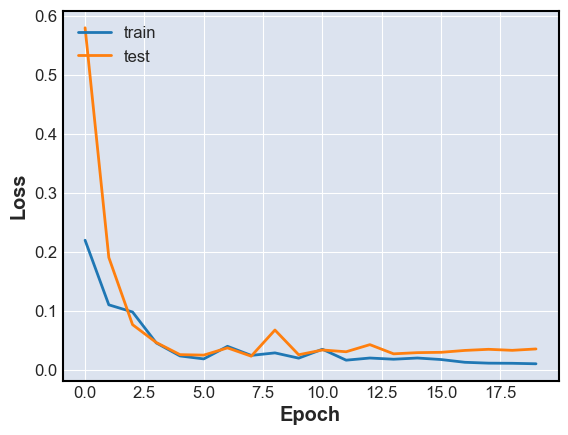

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [29]:
test_predictions = model.predict(X_test_scaled)

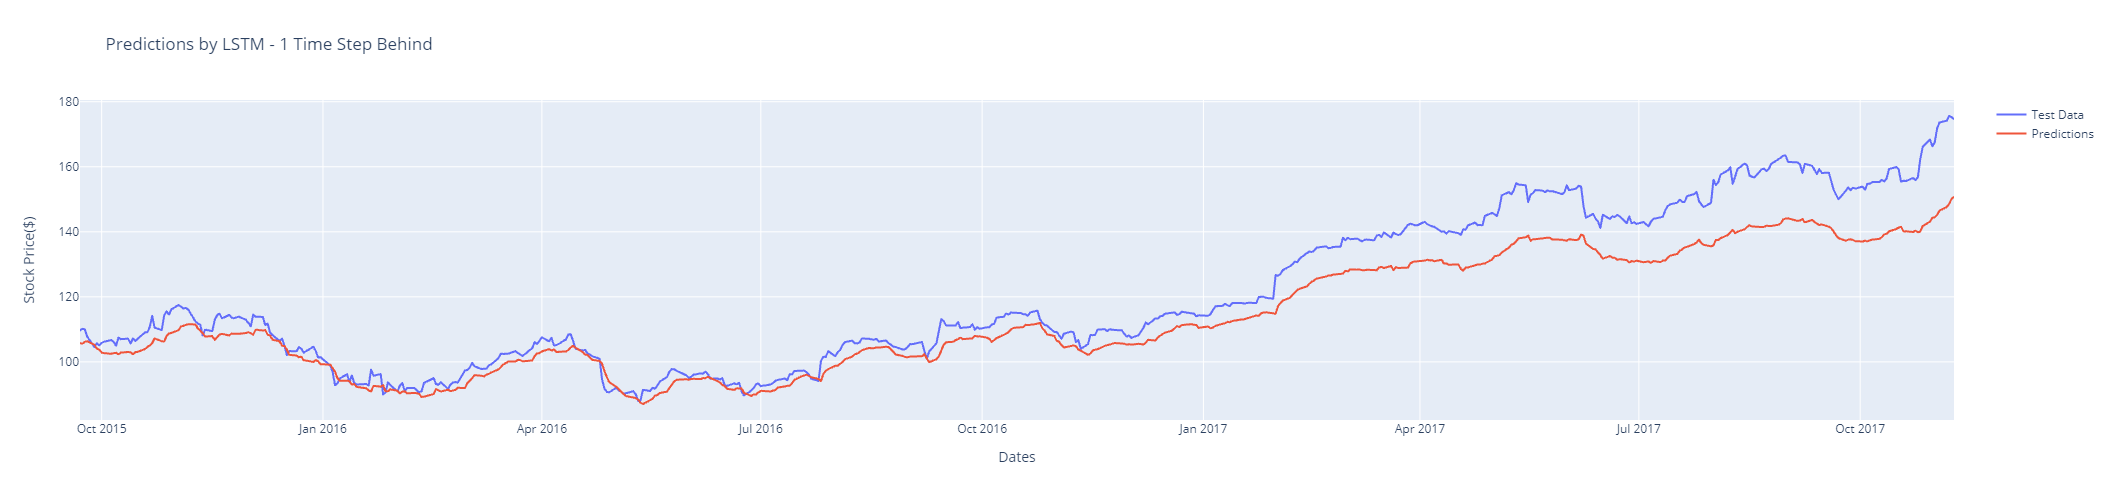

In [43]:
fig = go.Figure()

fig.add_trace(go.Scattergl(x=dates_test, y=y_test.ravel(), name='Test Data'))
fig.add_trace(go.Scattergl(x=dates_test, y=scaler_y.inverse_transform(test_predictions).ravel(), name='Predictions'))

fig.update_layout(
    title='Predictions by LSTM - 1 Time Step Behind',
    xaxis_title = 'Dates',
    yaxis_title = 'Stock Price($)',
    height = 500,
    width = 800,
)

fig.show()